## Data processing in Arcmap
##### 1. Calculate shape are: open attribute table—add Field—create a field name area—right click the field column—click Calculate Geometry 
https://blog.csdn.net/SYDBC/article/details/17759853
##### 2. Convert coordinate system:  Data management tools —Projections and Transformations—Raster—Project—input shapefile that need to change CRS—select ouput CRS
https://blog.csdn.net/zdw_wym/article/details/8025509

In [173]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats

## Read shapefile
#### slamm: New saltmarsh develop area in 2085 with the probability >=70%  (could be replace to other "uncertainty analysis" shapefile )
#### svi： vulnerability index (don't know what it means)


In [186]:
slamm = gpd.GeoDataFrame.from_file('output/NewMarsh3.shp')
svi = gpd.GeoDataFrame.from_file('output/svi.shp')

## Spatial join
##### Join svi and slamm dataset by intersecton. Calculate the total slamm affect area
##### id field in svi is the only primary key in svi 

In [187]:
borofh = gpd.sjoin(svi, slamm, op="intersects",how='left')

In [188]:
borofh.rename(columns= {'kk':'slamm_area'},inplace = True)
area_cal = borofh.groupby('id').sum()['slamm_area'].reset_index()

In [189]:
area_cal.head()

,id,slamm_area
0,1,0.000000
1,2,0.000000
2,3,1666.009521
3,4,0.000000
4,5,0.000000


###### Merge back to svi

In [190]:
final = svi.merge(area_cal,on='id')

In [179]:
final.to_file('combine_svi/flood.shp')

## Basic statistic test
##### affect : select tracts that new marsh develop in 2085 greater than 70% chances
##### naffect: select tracts that no new marsh develop or smaller than 30% chance

In [191]:
affect = final[final.slamm_area!=0]
naffect = final[final.slamm_area==0]

In [192]:
affect.head()

,id,tracts,name,area,leng,svi,geometry,slamm_area
2,3,000900,Battery Park City-Lower Manhattan,3.122059e+06,16484.098901,1.976388,(POLYGON ((-74.00078295275675 40.6942865156646...,1666.009521
36,2068,009300,Hunts Point,2.529189e+07,34312.132675,-0.904708,POLYGON ((-73.88799643614669 40.81666338586315...,7555.290237
80,75,026900,Kingsbridge Heights,4.243317e+06,12024.048182,-0.271373,POLYGON ((-73.90607917977972 40.87324242069398...,217.117286
81,76,026900,Kingsbridge Heights,4.243317e+06,12024.048182,-0.296861,POLYGON ((-73.90607917977972 40.87324242069398...,217.117286
94,92,002000,Lower East Side,1.368856e+06,4690.072720,14.850262,"POLYGON ((-73.97288971396699 40.7210882972193,...",50.000000


##### Histogram

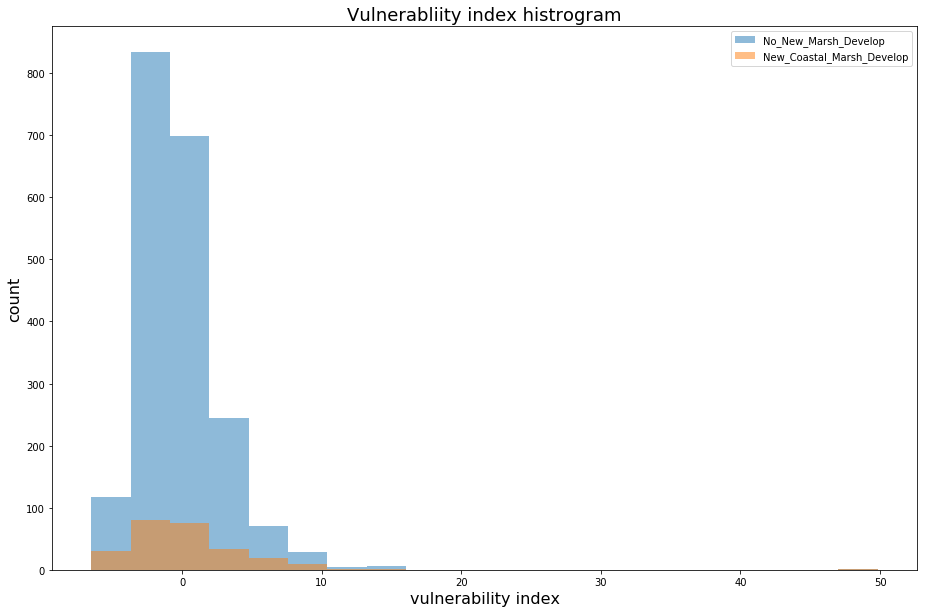

In [193]:
plt.figure(figsize=(15.5,10))
bins = 20
plt.hist(naffect['svi'], bins=bins, alpha = 0.5, label='No_New_Marsh_Develop')
plt.hist(affect['svi'], bins=bins, alpha = 0.5, label='New_Coastal_Marsh_Develop')

plt.legend(loc='upper right')
plt.title('Vulnerabliity index histrogram', fontsize=18)
plt.xlabel('vulnerability index', fontsize=16)
plt.ylabel('count',fontsize= 16)
plt.savefig('his_flood.png')

###### Non SLAMM affected tracts are much more than SLAMM affected tracts


##### Two sample t test

In [194]:
stats.ttest_ind(affect['svi'], naffect['svi'])

Ttest_indResult(statistic=2.770092362600031, pvalue=0.005649917923186048)

In [195]:
affect['svi'].mean()

0.39237621422887514

In [196]:
naffect['svi'].mean()

-0.2172565086680519

##### SLAMM affect area's svi are statistically higher than no affect area with 1% significant level